# Your First Deep Neural Network

This notebook implements a simple Multi-Layer Perceptron (MLP) on the CIFAR-10 dataset.


## GPU Setup

In [1]:
# ═══════════════════════════════════════════════════════════════════════════════
# GPU MEMORY GROWTH
# Enable memory growth to prevent TensorFlow from allocating all GPU memory
# ═══════════════════════════════════════════════════════════════════════════════
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU(s) available: {[gpu.name for gpu in gpus]}")
else:
    print("WARNING: No GPU detected, running on CPU")

2026-01-04 11:30:07.252140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


GPU(s) available: ['/physical_device:GPU:0']


## Imports

In [2]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras imports
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.datasets import cifar10

# Path setup for project utilities
import sys
sys.path.insert(0, '../..')  # For project root utils/

# Project utilities
from utils.wandb_utils import init_wandb, get_metrics_logger
from utils.callbacks import (
    LRFinder,
    get_lr_scheduler,
    get_early_stopping,
    LRLogger,
    GPUMemoryLogger  # Logs GPU memory per epoch
)
from utils.gpu_utils import (
    find_optimal_batch_size,
    calculate_adjusted_epochs,
    get_gpu_vram_gb,
    print_training_config
)

# W&B
import wandb
from wandb.integration.keras import WandbMetricsLogger

## Global Configuration

In [3]:
# ═══════════════════════════════════════════════════════════════════════════════
# GLOBAL CONFIGURATION
# All hyperparameters and settings are defined here for easy modification
# ═══════════════════════════════════════════════════════════════════════════════

# Reference values (original notebook settings for epoch scaling)
REFERENCE_BATCH_SIZE = 32   # Original book value
REFERENCE_EPOCHS = 10       # Original book value

# Batch size and epochs will be determined dynamically after model creation
# using find_optimal_batch_size() with OOM detection
BATCH_SIZE = REFERENCE_BATCH_SIZE  # Will be updated after model build
EPOCHS = REFERENCE_EPOCHS          # Will be updated after model build

# Learning rate (will be set by LRFinder)
LEARNING_RATE = "auto"

# Model configuration
NUM_CLASSES = 10            # CIFAR-10 classes
HIDDEN_LAYERS = [200, 150]  # Dense layer sizes

# W&B configuration
MODEL_TYPE = "dense_network"
DATASET_NAME = "cifar10"
OPTIMIZER_NAME = "adam"

## Load and Preprocess Data

In [4]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")
print(f"Image shape: {x_train.shape[1:]}")

/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Training samples: 50000
Test samples: 10000
Image shape: (32, 32, 3)


## W&B Initialization

In [5]:
# Initialize W&B for experiment tracking
# Note: BATCH_SIZE and EPOCHS use reference values here,
# they will be updated after dynamic batch sizing runs
run = init_wandb(
    name="02_01_deep_neural_network",
    config={
        "model": MODEL_TYPE,
        "dataset": DATASET_NAME,
        "num_classes": NUM_CLASSES,
        "hidden_layers": HIDDEN_LAYERS,
        "learning_rate": LEARNING_RATE,  # Will be updated after LRFinder
        "batch_size": BATCH_SIZE,        # Will be updated after dynamic sizing
        "epochs": EPOCHS,                # Will be updated after dynamic sizing
        "optimizer": OPTIMIZER_NAME,
    }
)

wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Model Architecture

In [6]:
# Build the MLP model using Keras Functional API
input_layer = Input((32, 32, 3))

x = Flatten()(input_layer)

# Build hidden layers from HIDDEN_LAYERS configuration
for units in HIDDEN_LAYERS:
    x = Dense(units, activation='relu')(x)

# Output layer
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(input_layer, output_layer)
model.summary()

I0000 00:00:1767526234.724863   21287 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       614,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,260 (2.47 MB)

 Trainable params: 646,260 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

## Dynamic Batch Size Optimization

In [7]:
# ═══════════════════════════════════════════════════════════════════════════════
# DYNAMIC BATCH SIZE OPTIMIZATION
# Uses binary search with OOM detection to find optimal batch size for this model
# ═══════════════════════════════════════════════════════════════════════════════

# Get GPU VRAM for reference
GPU_VRAM_GB = get_gpu_vram_gb()

# Find optimal batch size dynamically (tests actual memory usage)
BATCH_SIZE = find_optimal_batch_size(
    model=model,
    input_shape=(32, 32, 3),  # CIFAR-10 image shape
)

# Scale epochs to maintain equivalent training updates
EPOCHS = calculate_adjusted_epochs(REFERENCE_EPOCHS, REFERENCE_BATCH_SIZE, BATCH_SIZE)
EPOCHS = max(EPOCHS, 100)  # Ensure minimum epochs

# Update W&B config with actual values
wandb.config.update({
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "gpu_vram_gb": GPU_VRAM_GB,
}, allow_val_change=True)

# Print configuration summary
print_training_config(
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    model_params=model.count_params(),
    reference_batch=REFERENCE_BATCH_SIZE,
    reference_epochs=REFERENCE_EPOCHS,
    vram_gb=GPU_VRAM_GB
)

════════════════════════════════════════════════════════════════
DYNAMIC BATCH SIZE FINDER
════════════════════════════════════════════════════════════════
Model Parameters: 646,260
Estimated Model Memory: 9.9 MB (weights + optimizer + gradients)
Input Shape: (32, 32, 3)
────────────────────────────────────────────────────────────────
Testing batch sizes...
  batch_size=    2 ✓
  batch_size=    4 ✓
  batch_size=    8 ✓
  batch_size=   16 ✓
  batch_size=   32 ✓
  batch_size=   64 ✓
  batch_size=  128 ✓
  batch_size=  256 ✓
  batch_size=  512 ✓
  batch_size= 1024 ✓
  batch_size= 2048 ✓
  batch_size= 4096 ✓
────────────────────────────────────────────────────────────────
✓ No OOM detected. Using: 3680
════════════════════════════════════════════════════════════════
════════════════════════════════════════════════════════════════
TRAINING CONFIGURATION
════════════════════════════════════════════════════════════════
GPU VRAM:       8 GB
Model Params:   646,260
Batch Size:     3680 (referen

## Find Optimal Learning Rate

2026-01-04 11:30:59.403701: I external/local_xla/xla/service/service.cc:163] XLA service 0x703ed0206000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-04 11:30:59.403984: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2026-01-04 11:30:59.524423: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-04 11:31:00.259090: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
I0000 00:00:1767526264.593832   21432 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Optimal Learning Rate (Recommended): 0.000042


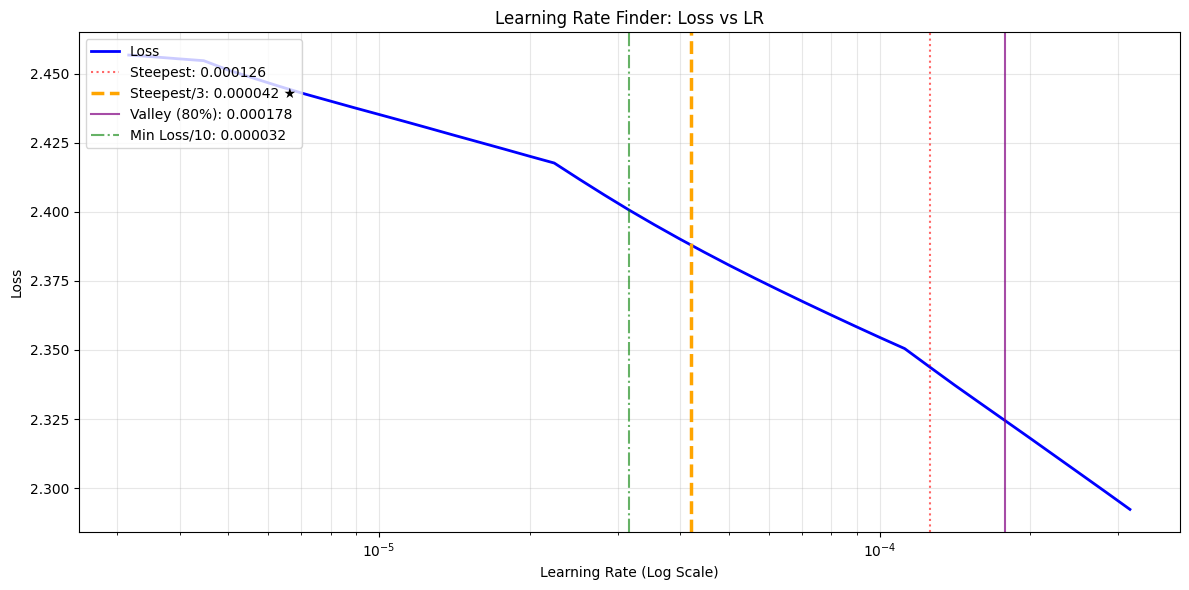

             LR FINDER RESULTS
  🔴 Steepest Gradient : 0.000126  (aggressive)
  🟠 Steepest / 3      : 0.000042  (balanced) ★ DEFAULT
  🟣 Valley (80%)      : 0.000178  (robust)
  🟢 Min Loss / 10     : 0.000032  (conservative)
  Selected Method: 'recommended' → LR = 0.000042

Optimal learning rate: 4.20e-05


In [8]:
# Clone model for LR finding (to avoid affecting the main model)
lr_model = tf.keras.models.clone_model(model)

# Compile with a very small initial learning rate
lr_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-6),
    metrics=['accuracy']
)

# Run LRFinder
lr_finder = LRFinder(min_lr=1e-6, max_lr=1e-1, steps=100)
lr_model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=4,
    callbacks=[lr_finder],
    verbose=0
)

# Visualize and get optimal LR
lr_finder.plot_loss()
LEARNING_RATE = lr_finder.get_optimal_lr()  # Uses 'recommended' method by default

# Update W&B config with optimal learning rate
wandb.config.update({"learning_rate": LEARNING_RATE})
print(f"\nOptimal learning rate: {LEARNING_RATE:.2e}")

## Train Model

In [9]:
# Instantiate GPU memory logger (stores history for visualization)
gpu_memory_logger = GPUMemoryLogger()

# Compile model with optimal learning rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

# Define full callback stack
callbacks = [
    WandbMetricsLogger(),                              # W&B logging
    get_lr_scheduler(monitor='val_loss', patience=2),  # Reduce LR on plateau
    get_early_stopping(monitor='val_loss', patience=5),# Stop if no improvement
    LRLogger(),                                        # Log learning rate
    gpu_memory_logger,                                 # Log GPU memory usage
]

# Train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.1222 - loss: 2.3059 Epoch 1: Learning Rate is 4.20e-05
  GPU Memory: 733 MB (peak: 975 MB)
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 719ms/step - accuracy: 0.1463 - loss: 2.2733 - val_accuracy: 0.1928 - val_loss: 2.2113 - learning_rate: 4.1964e-05
Epoch 2/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2039 - loss: 2.1942 Epoch 2: Learning Rate is 4.20e-05
  GPU Memory: 733 MB (peak: 975 MB)
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.2213 - loss: 2.1754 - val_accuracy: 0.2406 - val_loss: 2.1346 - learning_rate: 4.1964e-05
Epoch 3/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2514 - loss: 2.1223 Epoch 3: Learning Rate is 4.20e-05
  GPU Memory: 733 MB (peak: 975 MB)
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.2601 - loss: 2.1054 - val_accuracy: 0.2709 - val_loss: 2.0721 - learning_rate: 4.1964e-05
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2769 - loss: 2.0591 Epoch 4:

## Training Visualization

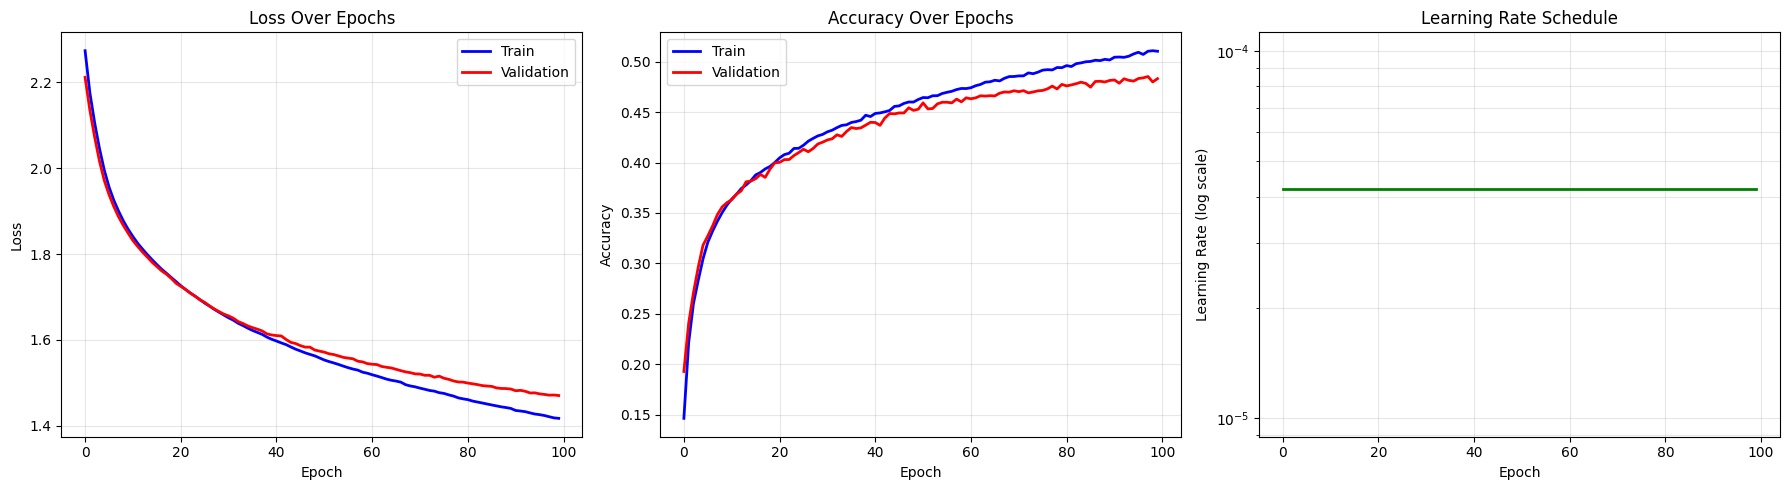


TRAINING SUMMARY
  Initial Loss    : 2.273250
  Final Loss      : 1.417637
  Min Loss        : 1.417637 (Epoch 100)
  Final Accuracy  : 0.5104
  Final Val Acc   : 0.4832
  Total Epochs    : 100
  Final LR        : 4.20e-05


In [10]:
# Plot training history
history_dict = history.history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training & Validation Loss
axes[0].plot(history_dict['loss'], 'b-', linewidth=2, label='Train')
axes[0].plot(history_dict['val_loss'], 'r-', linewidth=2, label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Training & Validation Accuracy
axes[1].plot(history_dict['accuracy'], 'b-', linewidth=2, label='Train')
axes[1].plot(history_dict['val_accuracy'], 'r-', linewidth=2, label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Learning Rate (LOG SCALE)
if 'learning_rate' in history_dict:
    axes[2].semilogy(history_dict['learning_rate'], 'g-', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate (log scale)')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].grid(True, which='both', alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'LR not tracked', ha='center', va='center', fontsize=14)
    axes[2].set_title('Learning Rate (Not Available)')

plt.tight_layout()
plt.show()

# Print summary
print(f"\n{'='*60}")
print("TRAINING SUMMARY")
print(f"{'='*60}")
print(f"  Initial Loss    : {history_dict['loss'][0]:.6f}")
print(f"  Final Loss      : {history_dict['loss'][-1]:.6f}")
print(f"  Min Loss        : {min(history_dict['loss']):.6f} (Epoch {history_dict['loss'].index(min(history_dict['loss'])) + 1})")
print(f"  Final Accuracy  : {history_dict['accuracy'][-1]:.4f}")
print(f"  Final Val Acc   : {history_dict['val_accuracy'][-1]:.4f}")
print(f"  Total Epochs    : {len(history_dict['loss'])}")
if 'learning_rate' in history_dict:
    print(f"  Final LR        : {history_dict['learning_rate'][-1]:.2e}")
print(f"{'='*60}")

## GPU Memory Analysis

Understanding GPU memory utilization is crucial for optimizing deep learning workloads.
This section analyzes the memory footprint of our MLP model.

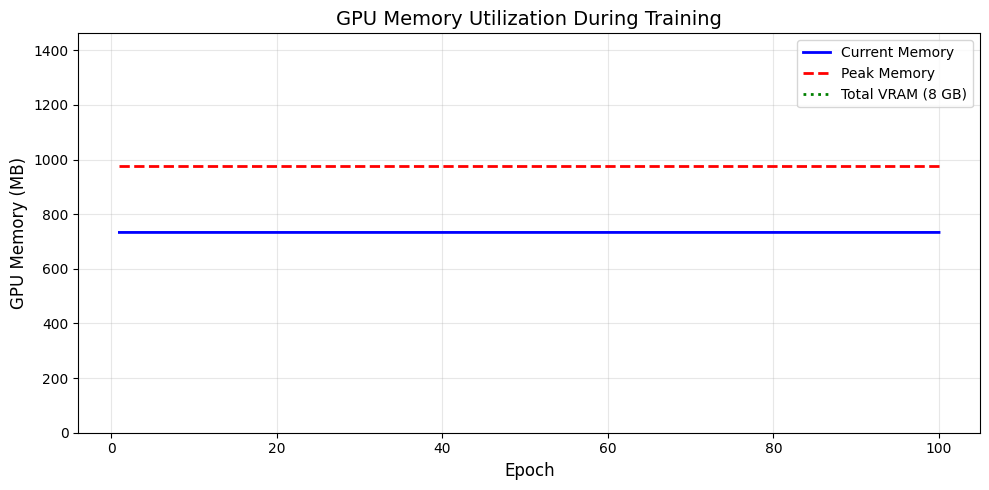


GPU MEMORY ANALYSIS
  Model Parameters    : 646,260
  Model Memory (est.) : 9.9 MB
  Average GPU Memory  : 733 MB
  Peak GPU Memory     : 975 MB
  Total VRAM Available: 8192 MB
  VRAM Utilization    : 11.9%


In [11]:
# ═══════════════════════════════════════════════════════════════════════════════
# GPU MEMORY ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════

# Extract GPU memory history
if gpu_memory_logger.memory_history:
    current_memory = [m[0] for m in gpu_memory_logger.memory_history]
    peak_memory = [m[1] for m in gpu_memory_logger.memory_history]
    epochs_range = range(1, len(current_memory) + 1)
    
    # Plot GPU memory over epochs
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(epochs_range, current_memory, 'b-', linewidth=2, label='Current Memory')
    ax.plot(epochs_range, peak_memory, 'r--', linewidth=2, label='Peak Memory')
    ax.axhline(y=GPU_VRAM_GB * 1024, color='g', linestyle=':', linewidth=2, 
               label=f'Total VRAM ({GPU_VRAM_GB} GB)')
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('GPU Memory (MB)', fontsize=12)
    ax.set_title('GPU Memory Utilization During Training', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Set y-axis to show full VRAM for context
    ax.set_ylim(0, max(peak_memory) * 1.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print memory statistics
    print(f"\n{'='*60}")
    print("GPU MEMORY ANALYSIS")
    print(f"{'='*60}")
    print(f"  Model Parameters    : {model.count_params():,}")
    print(f"  Model Memory (est.) : {model.count_params() * 16 / (1024**2):.1f} MB")
    print(f"  Average GPU Memory  : {np.mean(current_memory):.0f} MB")
    print(f"  Peak GPU Memory     : {max(peak_memory):.0f} MB")
    print(f"  Total VRAM Available: {GPU_VRAM_GB * 1024} MB")
    print(f"  VRAM Utilization    : {max(peak_memory) / (GPU_VRAM_GB * 1024) * 100:.1f}%")
    print(f"{'='*60}")
else:
    print("GPU memory data not available.")

### Why is GPU Memory Utilization Low?

**From a research perspective**, GPU memory consumption in neural networks is determined by:

1. **Model Parameters (Weights)**  
   - Each parameter requires 4 bytes (float32)
   - Our MLP has ~650K parameters ≈ 2.5 MB for weights alone

2. **Optimizer State (Adam)**  
   - Adam stores first moment (m) and second moment (v) for each parameter
   - This triples the parameter memory: 2.5 MB × 3 ≈ 7.5 MB

3. **Gradients**  
   - One gradient per parameter during backpropagation
   - Additional 2.5 MB during training

4. **Activations (Batch-dependent)**  
   - Activations are stored for backpropagation
   - Memory scales with: `batch_size × layer_outputs × 4 bytes`
   - For our small MLP: ~1-5 MB per batch

**Total Model Memory**: ~10-20 MB (regardless of batch size)

---

### Implications for Model Selection

| Model Type | Typical Parameters | Expected VRAM |
|------------|-------------------|---------------|
| Simple MLP (this notebook) | ~650K | 50-200 MB |
| CNN (CIFAR-10) | ~1-5M | 200-500 MB |
| VAE (CelebA 128×128) | ~5-20M | 2-4 GB |
| GAN (WGAN-GP) | ~20-50M | 4-8 GB |
| Transformers | ~100M+ | 8+ GB |

**Key Insight**: To fully utilize GPU memory, use larger models (CNNs, VAEs, GANs) 
or higher-resolution inputs. The dynamic batch finder optimizes batch size, but 
small models inherently cannot consume large amounts of VRAM.

## Model Evaluation

In [12]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"\nTest accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4832 - loss: 1.4708

Test accuracy: 0.4832


## Analysis

In [13]:
# Class names for CIFAR-10
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'])

# Make predictions
preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


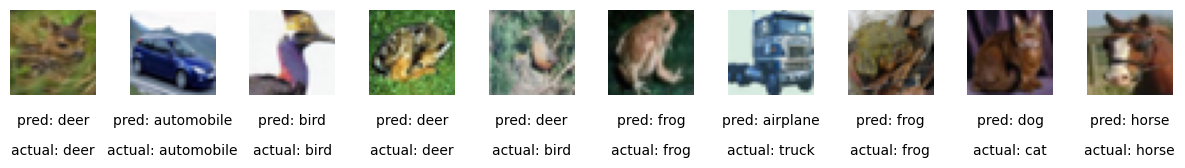

In [14]:
# Visualize some predictions
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, f'pred: {preds_single[idx]}', fontsize=10, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.7, f'actual: {actual_single[idx]}', fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

plt.show()

## Cleanup

In [15]:
# Finish W&B run
wandb.finish()
print("W&B run finished successfully.")

batch_finder/model_memory_mb,▁
batch_finder/model_params,▁
batch_finder/optimal_batch_size,▁
epoch/accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
epoch/epoch,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▂▂▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch/val_loss,█▇▇▆▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
gpu_memory_mb,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
+2,...


W&B run finished successfully.


In [16]:
# ═══════════════════════════════════════════════════════════════════════════════
# CLEANUP: Restart kernel to fully release GPU memory
# ═══════════════════════════════════════════════════════════════════════════════
# TensorFlow/CUDA does not release GPU memory within a running Python process.
# Restarting the kernel is the only guaranteed way to free all GPU resources.
#
# NOTE: Only run this cell after all work is complete and saved.
#       The kernel restart will clear all variables and outputs.

# import IPython
# print("Restarting kernel to release GPU memory...")
# IPython.Application.instance().kernel.do_shutdown(restart=True)